In [ ]:
from ipy_oxdna.umbrella_sampling import MeltingUmbrellaSampling
from ipy_oxdna.oxdna_simulation import SimulationManager

import numpy as np
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex', 'bright'])

#### Initalize parameters and the umbrella sampling object, creating the directories where the simulations will be stored

In [3]:
path = os.path.abspath('./')

file_dir_name = 'oxdna_files'  #'NAME_OF_DIR_CONTAINING_OXDNA_DAT_TOP'
file_dir = join(path, file_dir_name) #f'{path}/{file_dir_name}'

sim_dir_name = '8_nt_duplex_melting_tutorial' #'CHOSEN_NAME_WHERE_SIMULATION_WILL_BE_STORED'
sim_dir = join(file_dir, sim_dir_name)   #f'{path}/{sim_dir_name}'

# Initialize the umbrella sampling object, this will create the simulation directory

# Clean build has 3 options, False, True and 'force' False will not allow you to overwrite
# existing simulation directories, True will overwrite existing simulation directories after asking for confirmation
# 'force' will overwrite existing simulation directories without asking for confirmation
us = MeltingUmbrellaSampling(file_dir, sim_dir, clean_build=True)

# The simulation manager object is used to run the simulation is non-blocking subprocesses,
# and will optimally allocate the simulations to available resources
simulation_manager = SimulationManager()

# Indexes of nucleotides to apply forces to and measure distance between (Order Parameter(OP))
com_list = '8,9,10,11,12,13,14,15'
ref_list = '7,6,5,4,3,2,1,0'

# Order of input nucleotides is import to collect the hb_contacts CV correctly, irrelevant for all else
com_list = ','.join(sorted(com_list.split(','), key=int)[::-1])
ref_list = ','.join(sorted(ref_list.split(','), key=int))

# Minimum and maximum distance between nucleotides the simulations will attempt to pull the OP 
xmin = 0
xmax = 15

# Number of simulation windows/replicas
n_windows = 50

# Stiffness of the COM harmonic bias potential
stiff = 3

# Temperature of the simulation
temperature = "40C"

# Starting_r0 is only relevant if you run the pre_equlibration step,
# needed if you have large stiffness values and range of the OP is large but dosen't hurt to always run quickly
# Not possible to know before you run the simulation but you can run a till they print once,
# terminate and paste the starting_r0 value from the output file
starting_r0 = 0.4213

# Frequecny of printing the CVs to file
print_every = 1e4

# Name of file to save all but one of the CVs to, it is possible this cannot be changed
obs_filename = 'all_observables.txt'

# Name of file to save the hb_contacts CV to
hb_contact_filename = 'hb_contacts.txt'

# Number of simulation steps to run for each window
pre_eq_steps = 1e6  # This only need to short
eq_steps = 5e6  # This needs to be long enough to equilibrate the system
prod_steps = 2e8 # This needs to be long enough to get converged free energy profiles (methods to check are provided)

# Setup the custom hb_contacts CV
particle_indexes = [com_list, ref_list]
hb_contact_observable = [{'idx':particle_indexes, 'name':f'{hb_contact_filename}', 'print_every':int(print_every)}]

# oxDNA Simulation parameters
pre_equlibration_parameters = {
    'backend':'CPU', 'steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps // 10}',
    'print_conf_interval':f'{pre_eq_steps // 2}', "CUDA_list": "no",'use_edge': 'false',
    'refresh_vel': '1','fix_diffusion': '0', 'T':f'{temperature}'}

equlibration_parameters = {
    'backend':'CPU','steps':f'{eq_steps}','print_energy_every': f'{eq_steps// 10}',
    'print_conf_interval':f'{eq_steps // 2}', "CUDA_list": "no",'use_edge': 'false',
    'refresh_vel': '1', 'fix_diffusion': '0', 'T':f'{temperature}'}

production_parameters = {
    'backend':'CPU', 'steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
    'print_conf_interval':f'{prod_steps}', "CUDA_list": "no", 'use_edge': 'false',
    'refresh_vel': '1','fix_diffusion': '0', 'T':f'{temperature}'}


#### Build the pre-equlibration simulations, which will pull the windows to designated com distance

In [ ]:
# This will build the pre_equlibration runs and queue them in the simulation manager

us.build_pre_equlibration_runs(
    simulation_manager, n_windows, com_list, ref_list, stiff, xmin, xmax,
    pre_equlibration_parameters, starting_r0, pre_eq_steps, continue_run=False,
    # If you want to continue a previous simulation set continue_run=int(n_steps)
    
    print_every=print_every, observable=True, protein=None, sequence_dependant=True,
    force_file=False, name=obs_filename, custom_observable=hb_contact_observable)

#### Run the simulations in non-blocking subprocesses while optimally allocating computational resources. It will only run as many simulations as you have avalible cpus minus one

In [ ]:
simulation_manager.run(cpu_run=True) # This will run the simulation in the background (non-blocking)
#simulation_manager.worker_manager(cpu_run=True) # This will run the simulation in the foreground (blocking)

#### Visualize simulation progress though com distance vs simulation step and number of hydrogen bonds vs simulations steps

In [ ]:
# Read collected variable into us.obs_df a list of n_windows dataframes
# The number of datapoints can vary between windows during run time, disallowing arrays
us.observables_list = []
us.initialize_observables(com_list, ref_list, print_every=print_every, name=obs_filename)

sim_type = 'pre_eq' # 'pre_eq', 'eq', 'prod'
us.analysis.read_all_observables(sim_type) 

us.analysis.plot_melting_CVs(rolling_window=1)
display(us.obs_df[0].head())

#### Open oxview interface with last saved conf and print energy

In [ ]:
# This will provide access to the pre_equlibration simulations information
pre_eq_sims = us.pre_equlibration_sims
# us.equlibration_sims, us.production_sims are also available

# View conf interactivly in jupyter notebook
simulation_window_to_view = 7
pre_eq_sims[simulation_window_to_view].analysis.view_last() # .view_init(), .view_conf(conf_number), .get_conf_count()

# Plot the energy of the pre_equlibration simulations
fig, ax = plt.subplots(figsize=(8, 6))
for sim in pre_eq_sims:
    sim.analysis.plot_energy(fig=fig, ax=ax)
plt.legend()


#### Build equlibration run to bring strucutres to equlibrated state after pulling

In [ ]:
us.build_equlibration_runs(
    simulation_manager, n_windows, com_list, ref_list,
    stiff, xmin, xmax, equlibration_parameters, continue_run=False,
    
    print_every=print_every, observable=True, protein=None, sequence_dependant=True,
    force_file=False, name=obs_filename, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.run(cpu_run=True)

#### Visualize equlibration simulation progress

In [ ]:
# Read collected variable into us.obs_df a list of n_windows dataframes
# The number of datapoints can vary between windows during run time, disallowing arrays
us.observables_list = []
us.initialize_observables(com_list, ref_list, print_every=print_every, name=obs_filename)

sim_type = 'eq' # 'pre_eq', 'eq', 'prod'
us.analysis.read_all_observables(sim_type) 

us.analysis.plot_melting_CVs(rolling_window=1)
display(us.obs_df[0].head())

#### Open oxview interface with last saved conf and print energy

In [ ]:
# This will provide access to the pre_equlibration simulations information
eq_sims = us.equlibration_sims
# us.equlibration_sims, us.production_sims are also available

# View conf interactivly in jupyter notebook
simulation_window_to_view = 7
eq_sims[simulation_window_to_view].analysis.view_last() # .view_init(), .view_conf(conf_number), .get_conf_count()

# Plot the energy of the pre_equlibration simulations
fig, ax = plt.subplots(figsize=(8, 6))
for sim in eq_sims:
    sim.analysis.plot_energy(fig=fig, ax=ax)
plt.legend()


#### Run the production simulations

In [ ]:
us.build_production_runs(
    simulation_manager, n_windows, com_list, ref_list,
    stiff, xmin, xmax, production_parameters, continue_run=False,
    
    print_every=print_every, observable=True, protein=None, sequence_dependant=True,
    force_file=False, name=obs_filename, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.run(cpu_run=True)

In [ ]:
simulation_manager.terminate_all() # this method can be used to end all running simulations

#### Visualize production simulation progress

,com_distance,hb_list,force_energy_0,force_energy_1,kinetic_energy,backbone,bonded_excluded_volume,stacking,nonbonded_excluded_volume,hydrogen_bonding,cross_stacking,coaxial_stacking,debye_huckel,steps,hb_contact
0,0.4213,8.0,0.000000,0.000000,0.354255,0.035818,0.0,-1.014242,0.0,-0.322364,-0.113485,0.0,0.000720,0,0.999999
1,0.3379,7.0,0.000633,0.000633,0.288445,0.039426,0.0,-1.000445,0.0,-0.303388,-0.133374,0.0,0.000938,10000,0.999991
2,0.4591,8.0,0.000152,0.000152,0.366948,0.050806,0.0,-1.029075,0.0,-0.294662,-0.084160,0.0,0.000937,20000,0.999994
3,0.4334,7.0,0.000023,0.000023,0.336705,0.050623,0.0,-0.998241,0.0,-0.246597,-0.099578,0.0,0.000886,30000,0.999999
4,0.3586,8.0,0.000313,0.000313,0.386201,0.016505,0.0,-0.990070,0.0,-0.310735,-0.063325,0.0,0.000700,40000,0.999997


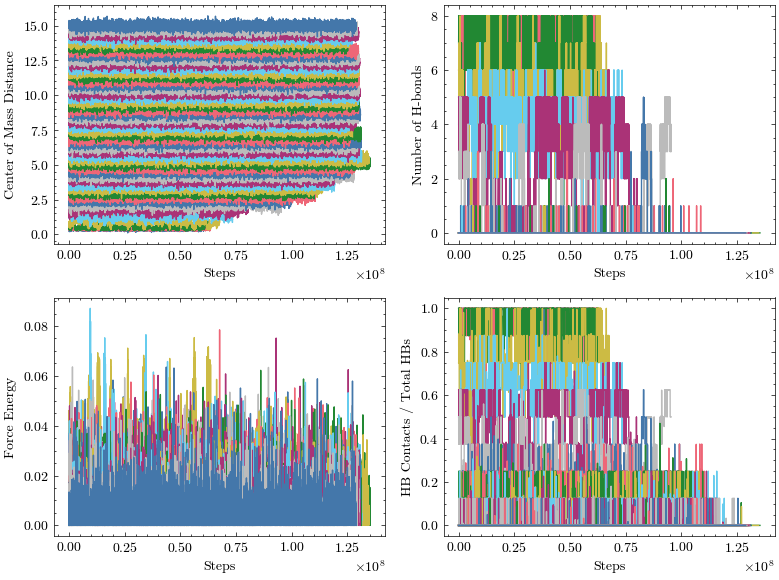

In [4]:
# Read collected variable into us.obs_df a list of n_windows dataframes
# The number of datapoints can vary between windows during run time, disallowing arrays
us.observables_list = []
us.initialize_observables(com_list, ref_list, print_every=print_every, name=obs_filename)

sim_type = 'prod' # 'pre_eq', 'eq', 'prod'
us.analysis.read_all_observables(sim_type) 

us.analysis.plot_melting_CVs(rolling_window=1)
display(us.obs_df[0].head())

In [ ]:
# This will provide access to the pre_equlibration simulations information
prod_sims = us.production_sims
# us.equlibration_sims, us.production_sims are also available

# View conf interactivly in jupyter notebook
prod_sims[0].analysis.view_last() # .view_init(), .view_conf(conf_number), .get_conf_count()

# Plot the energy of the pre_equlibration simulations
fig, ax = plt.subplots(figsize=(8, 6))
for sim in prod_sims:
    sim.analysis.plot_energy(fig=fig, ax=ax)
plt.legend()


#### Free energy profile as a function of the number of hydrogen bonds and com distance with temperature interpolation and convergence analysis for melting temperature calculation

In [ ]:
# Only run this once you have production simulations running

temp_range = np.arange(20, 70, 2)
# temp_range = np.array([52])
n_bins = 50
xmin = 0
xmax = 15
max_hb = 8
umbrella_stiff = 3
epsilon = 1e-7
convergence_slice = 2

us.discrete_and_continuous_converg_analysis(
    convergence_slice, temp_range,
    n_bins, xmin, xmax, umbrella_stiff, max_hb,
    epsilon=epsilon, reread_files=False)

#### Plot free energy profiles and melting curve

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, dpi=600, figsize=(6,2.5), tight_layout=True)

bin_centers, bin_edges = us.get_bins(xmin, xmax, n_bins=n_bins)
bin_centers = bin_centers*0.8518

for idx, free in enumerate(us.convergence_free):            
    sub_index = free[0].argmin()
    for f, temp_val in zip(free, temp_range):
        if idx == 0:
            ax1.plot(bin_centers, f, label=f'{temp_val}C WHAM Custom') 
        else:
            ax1.plot(bin_centers, f, label=f'{temp_val}C WHAM Custom')
ax1.set_xlabel('Distance (nm)')
ax1.set_ylabel('Free Energy (kT)')

for idx, (inverted_finfs, x_fit, y_fit, Tm) in enumerate(zip(us.convergence_inverted_finfs, us.convergence_x_fit, us.convergence_y_fit, us.convergence_Tm)):
    ax2.scatter(temp_range, inverted_finfs, marker='o')
    ax2.plot(x_fit, y_fit, linestyle='--', linewidth=2, label=f'Tm = {Tm:.2f} C Slice {idx}')
    ax2.axvline(x=Tm, color='r', linestyle='--', linewidth=2)#, label=f'Tm = {Tm:.2f} C')
    ax2.legend(fontsize=6)   
ax2.set_xlabel('Temperature (C)')
ax2.set_ylabel('Fraction unbound')
fig.tight_layout()

#### Multistate bennet acceptance ratio analysis for restrained umbrella sampling and temperature interpolation for arbitary collected variable free energy profile

In [ ]:
# You will need to reinitalize the observables if you did not build the dirs in your current kernel, I want to fix this
us.observables_list = []
us.initialize_observables(com_list, ref_list, print_every=print_every, name=obs_filename)


us.pymbar.run_mbar_fes(
    reread_files=True,
    sim_type='prod',
    restraints=False,
    force_energy_split=True)

max_hb = 8
temp_range = np.array([42, 52, 62])

free_n_hb, bin_n_hb, dfree_n_hb = us.pymbar.n_hb_fes_hist(max_hb, temp_range=temp_range)
free_i_com, bin_com, dfree_com = us.pymbar.com_fes_hist(n_bins=20, temp_range=temp_range)

In [ ]:
plt.figure()
for idx, free in enumerate(free_n_hb):
    plt.plot(bin_n_hb, free, label=f'{temp_range[idx]}C')

plt.figure()
for idx, free in enumerate(free_i_com):
    plt.plot(bin_com, free, label=f'{temp_range[idx]}C')
plt.legend()